In [4]:
#importing libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix

In [6]:
#importing dataset
import kagglehub

# Download latest version
path = kagglehub.dataset_download("navoneel/brain-mri-images-for-brain-tumor-detection")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-mri-images-for-brain-tumor-detection


In [7]:
#Prepare Dataset
import shutil
from sklearn.model_selection import train_test_split

# Define paths
tumor_path = "/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes"
no_tumor_path = "/kaggle/input/brain-mri-images-for-brain-tumor-detection/no"

# Create train/val split folders
base_dir = 'brain_tumor_dataset'
os.makedirs(base_dir, exist_ok=True)

for split in ['train', 'val']:
    for category in ['yes', 'no']:
        os.makedirs(os.path.join(base_dir, split, category), exist_ok=True)

# Split and move files
def split_data(source_dir, train_dir, val_dir, split_ratio=0.8):
    files = os.listdir(source_dir)
    np.random.shuffle(files)
    split = int(split_ratio * len(files))
    train_files = files[:split]
    val_files = files[split:]

    for f in train_files:
        shutil.copy(os.path.join(source_dir, f), os.path.join(train_dir, f))
    for f in val_files:
        shutil.copy(os.path.join(source_dir, f), os.path.join(val_dir, f))

split_data(tumor_path, f'{base_dir}/train/yes', f'{base_dir}/val/yes')
split_data(no_tumor_path, f'{base_dir}/train/no', f'{base_dir}/val/no')

In [9]:
#data augmentaions and generators
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=10, zoom_range=0.1, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(f'{base_dir}/train', target_size=(150, 150), batch_size=16, class_mode='binary')
val_generator = val_datagen.flow_from_directory(f'{base_dir}/val', target_size=(150, 150), batch_size=16, class_mode='binary')


Found 202 images belonging to 2 classes.
Found 51 images belonging to 2 classes.


In [11]:
#Building CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Train Model
history = model.fit(train_generator, epochs=10, validation_data=val_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 966ms/step - accuracy: 0.6485 - loss: 0.6600 - val_accuracy: 0.7451 - val_loss: 0.5685
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7825 - loss: 0.4926 - val_accuracy: 0.7647 - val_loss: 0.5464
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 970ms/step - accuracy: 0.8427 - loss: 0.4600 - val_accuracy: 0.7451 - val_loss: 0.5447
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 825ms/step - accuracy: 0.7275 - loss: 0.5347 - val_accuracy: 0.7647 - val_loss: 0.5416
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 907ms/step - accuracy: 0.7792 - loss: 0.5043 - val_accuracy: 0.7843 - val_loss: 0.5179
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 935ms/step - accuracy: 0.8013 - loss: 0.4694 - val_accuracy: 0.7843 - val_loss: 0.4721
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 972ms/step - accuracy: 0.8136 - loss: 0.4445 - val_accuracy: 0.7843 - val_loss: 0.4302
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 940ms/step - accuracy: 0.7348 - loss: 0.4973 - val_accurac

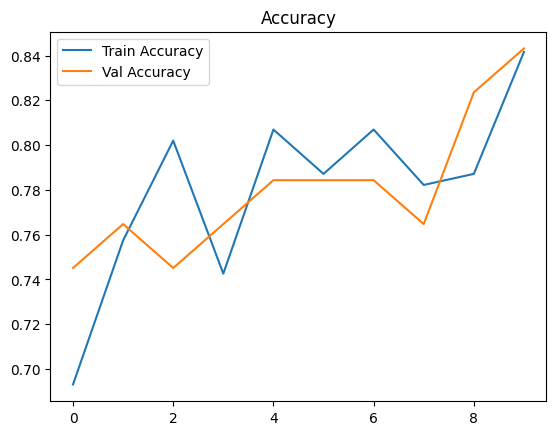

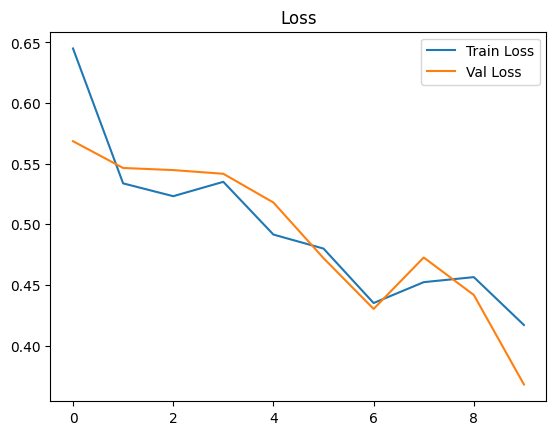

In [13]:
# Accuracy/Loss Curves
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 377ms/step


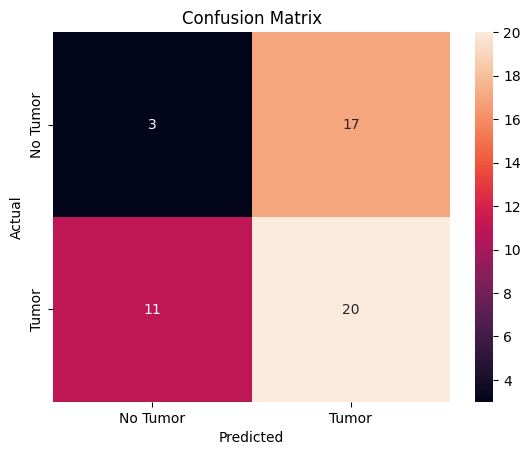

              precision    recall  f1-score   support

    No Tumor       0.21      0.15      0.18        20
       Tumor       0.54      0.65      0.59        31

    accuracy                           0.45        51
   macro avg       0.38      0.40      0.38        51
weighted avg       0.41      0.45      0.43        51



In [14]:
#Confusion Matrix
import numpy as np

# Predict on validation data
val_generator.reset()
y_pred = (model.predict(val_generator) > 0.5).astype("int32")
y_true = val_generator.classes

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['No Tumor', 'Tumor'], yticklabels=['No Tumor', 'Tumor'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names=['No Tumor', 'Tumor']))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step


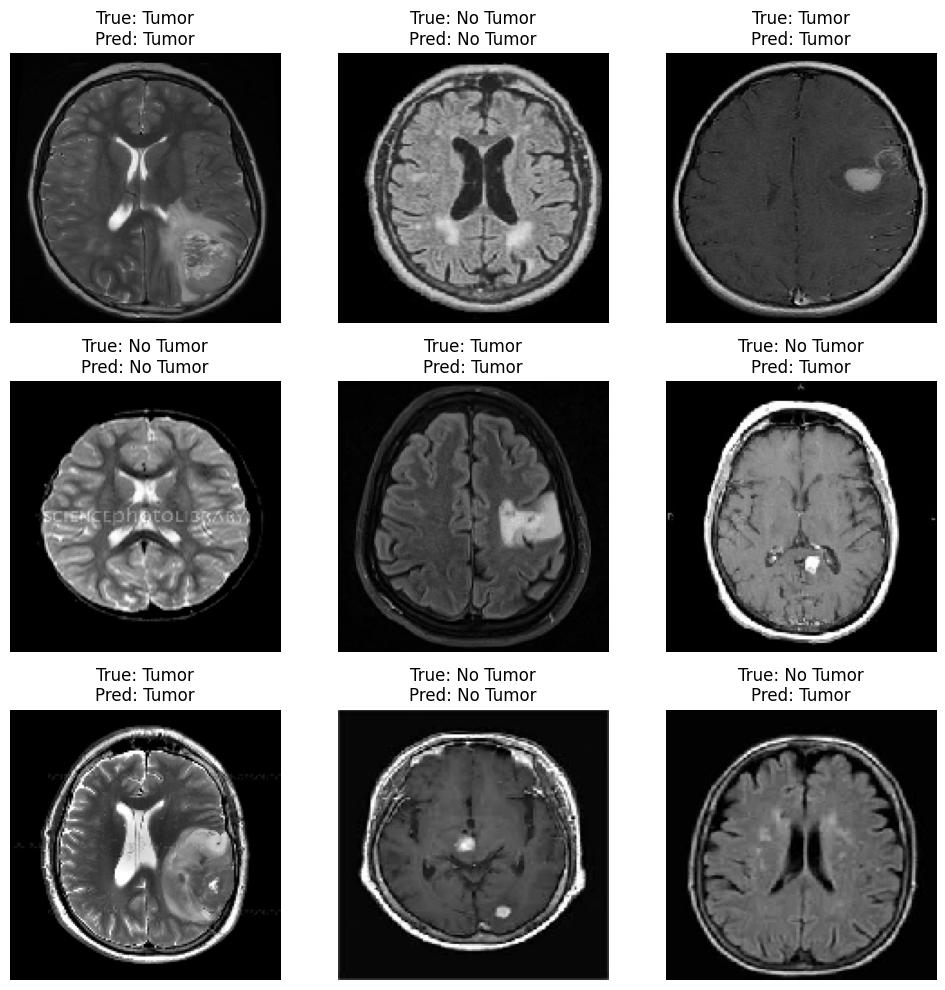

In [15]:
#Visualize Predictions

import matplotlib.pyplot as plt

val_generator.reset()
x, y = next(val_generator)

preds = model.predict(x) > 0.5

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x[i])
    plt.title(f"True: {'Tumor' if y[i] else 'No Tumor'}\nPred: {'Tumor' if preds[i] else 'No Tumor'}")
    plt.axis('off')
plt.tight_layout()
plt.show()
